In [76]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels 
import seaborn as sns
import scipy.stats as ss
import pylab
import pymysql
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts 
import sklearn
import arch
import datetime as dt


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from tqdm import tqdm
from time import sleep
sns.set()

In [78]:
symbols = ['BTCUSDT','ETHUSDT', 'ADAUSDT', 'BNBUSDT']

In [10]:
df.head(10)

,Close
Date,
2020-01-01,7200.85
2020-01-02,6965.71
2020-01-03,7344.96
2020-01-04,7354.11
2020-01-05,7358.75
2020-01-06,7758.00
2020-01-07,8145.28
2020-01-08,8055.98
2020-01-09,7817.76


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 998 entries, 2020-01-01 to 2022-09-24
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   998 non-null    float64
dtypes: float64(1)
memory usage: 15.6 KB


In [12]:
df.describe()

,Close
count,998.000000
mean,29937.088697
std,17564.705149
min,4800.000000
25%,11123.390000
50%,30342.690000
75%,44415.650000
max,67525.830000


In [13]:
df.isna().sum()

Close    0
dtype: int64

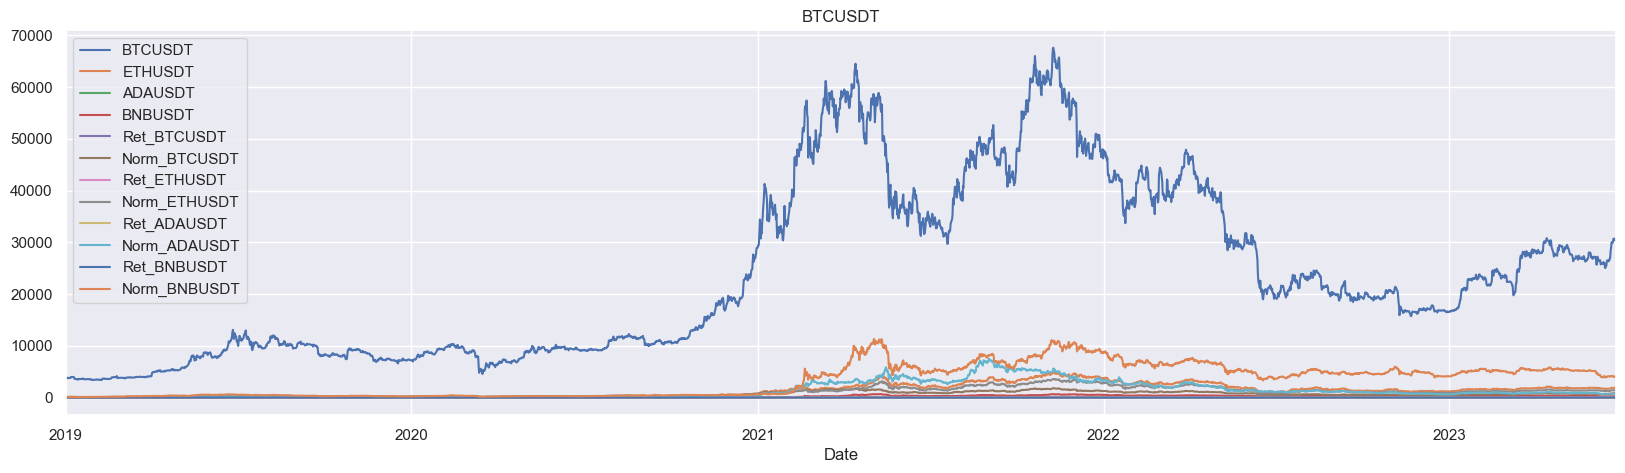

In [92]:
df.plot(figsize=(20, 5), title='BTCUSDT')
plt.savefig('../reports/figures/btcusdt_plot')
plt.show()

## QQ Plot

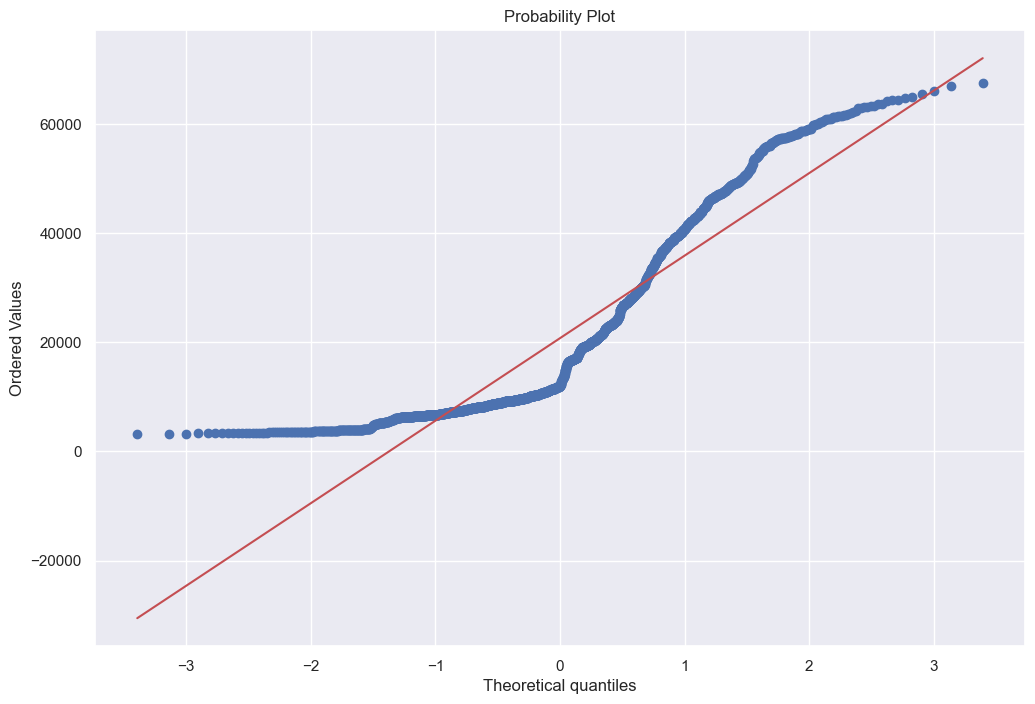

In [18]:

fig, ax = plt.subplots(figsize=(12, 8)) 
ss.probplot(df.Close, plot=pylab)
plt.savefig('../reports/figures/btcusdt_qqplot')
pylab.show()


### The QQ Plot indicates that values are not normally distributed, more data in the 5000 to 2000 region 

## Test of stationality
##### ADF Test Results for BTCUSDT Closing Prices

The Augmented Dickey-Fuller (ADF) test was conducted on the BTCUSDT closing prices. The purpose of this test is to determine whether the series is stationary or non-stationary.

- Test Statistic: -1.465
- p-value: 0.55

The test statistic of -1.658 is less negative than the critical values at all significance levels (1%, 5%, and 10%). Additionally, the p-value of 0.453 is greater than the commonly used significance level of 0.05. These results indicate that there is insufficient evidence to reject the null hypothesis of non-stationarity.

Therefore, based on the ADF test, the BTCUSDT closing prices are likely non-stationary, suggesting the presence of trends or other forms of non-random behavior.


In [19]:
sts.adfuller(df.Close)

(-1.3854479587891217,
 0.5892323260114144,
 24,
 1975,
 {'1%': -3.433665351698571,
  '5%': -2.8630045337025267,
  '10%': -2.567549656849864},
 32811.23288692689)

## Test of Seasonality

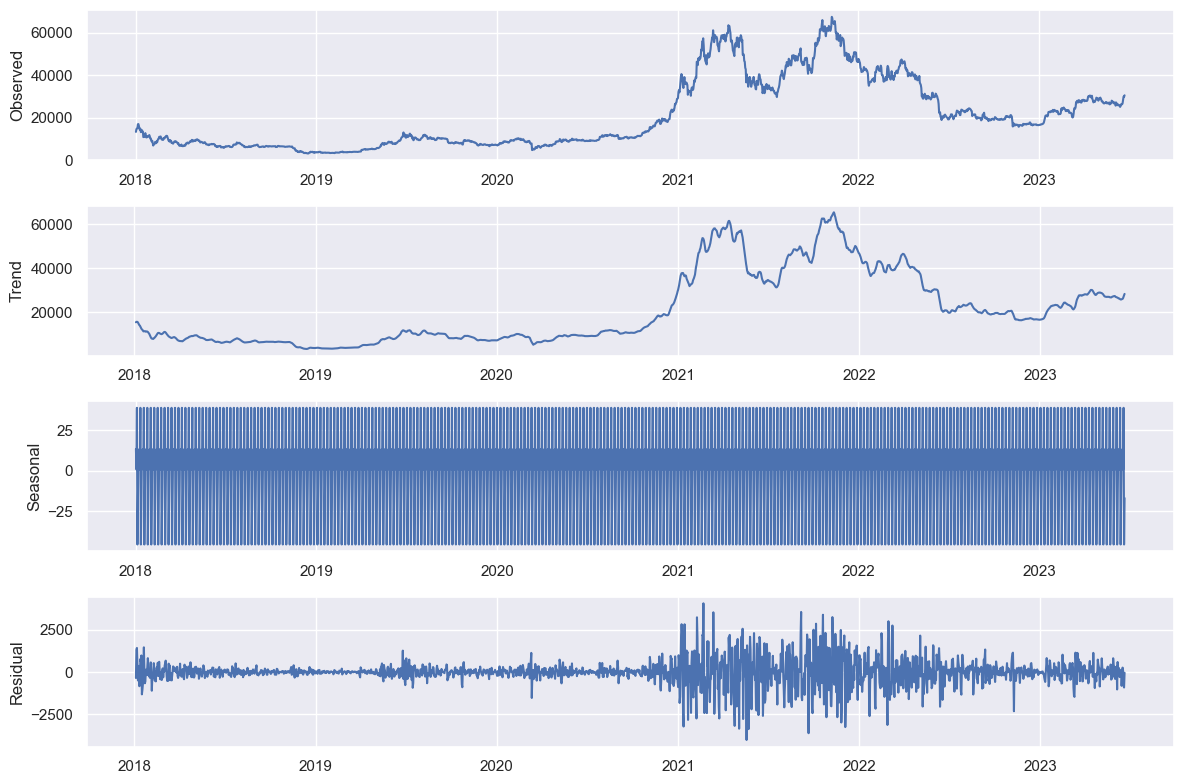

In [20]:

d_sec_add = seasonal_decompose(df.Close, model='additive')

fig, axes = plt.subplots(4, 1, figsize=(12, 8)) 

axes[0].plot(d_sec_add.observed)
axes[0].set_ylabel('Observed')

axes[1].plot(d_sec_add.trend)
axes[1].set_ylabel('Trend')

axes[2].plot(d_sec_add.seasonal)
axes[2].set_ylabel('Seasonal')

axes[3].plot(d_sec_add.resid)
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.savefig('../reports/figures/btcusdt_decompose_additive')
plt.show()


### seasonal decompose plot show that there is no seasonality in the data which means that the btcusdt is not a seasonal data also the residual shows that there was some instablity in the data in 2021 up untill eaily 2022

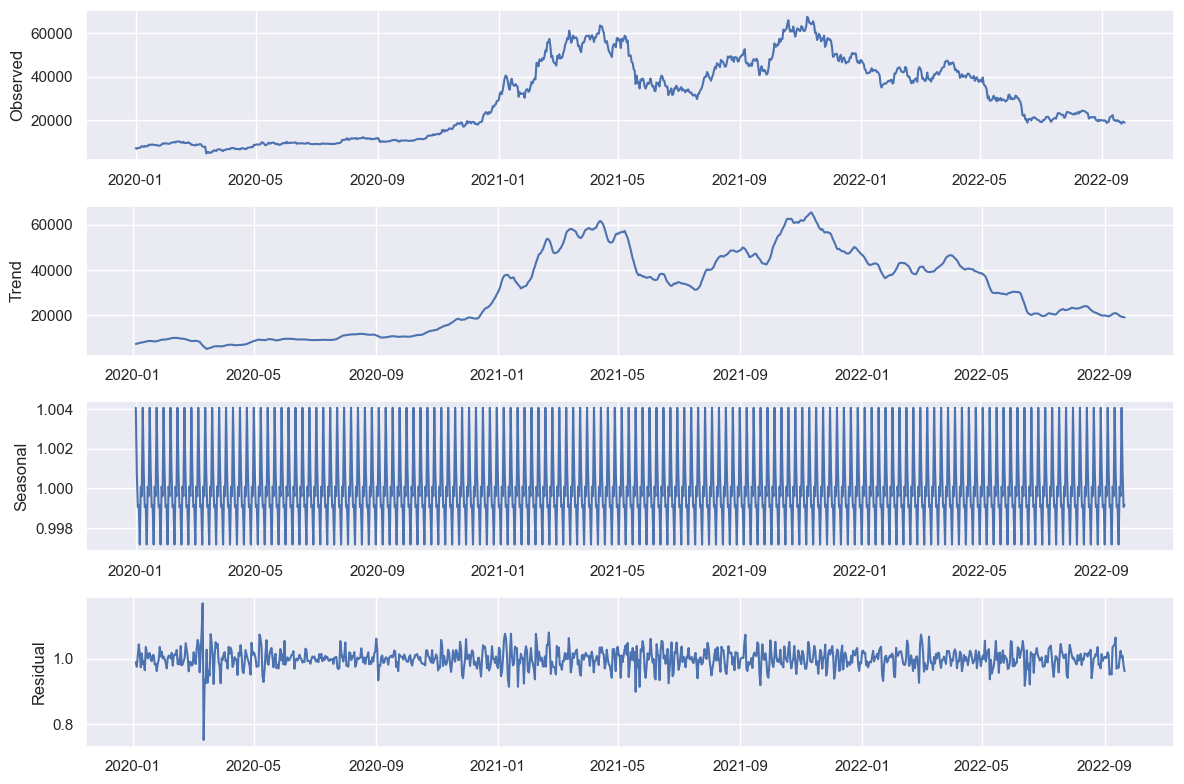

In [18]:
d_sec_mul = seasonal_decompose(df.Close, model='multiplicative')

fig, axes = plt.subplots(4, 1, figsize=(12, 8)) 

axes[0].plot(d_sec_mul.observed)
axes[0].set_ylabel('Observed')

axes[1].plot(d_sec_mul.trend)
axes[1].set_ylabel('Trend')

axes[2].plot(d_sec_mul.seasonal)
axes[2].set_ylabel('Seasonal')

axes[3].plot(d_sec_mul.resid)
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.savefig('../reports/figures/btcusdt_decompose_multiplicative')
plt.show()


## Plotting ACF

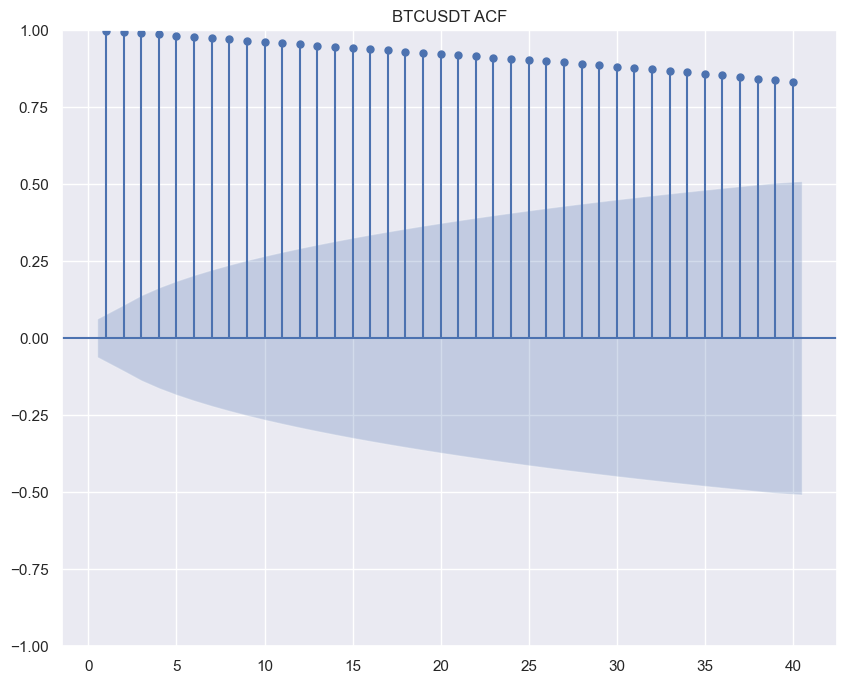

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))  
sgt.plot_acf(df.Close, lags=40, zero=False, ax=ax)
plt.title("BTCUSDT ACF")
plt.savefig('../reports/figures/btcusdt_acf')
plt.show()


### This acf suggest that coefficient are signficant which shows time dependance in the data also the shows that prices 30 days ago and beyond isnt really a good indicator of current prices

## PACF

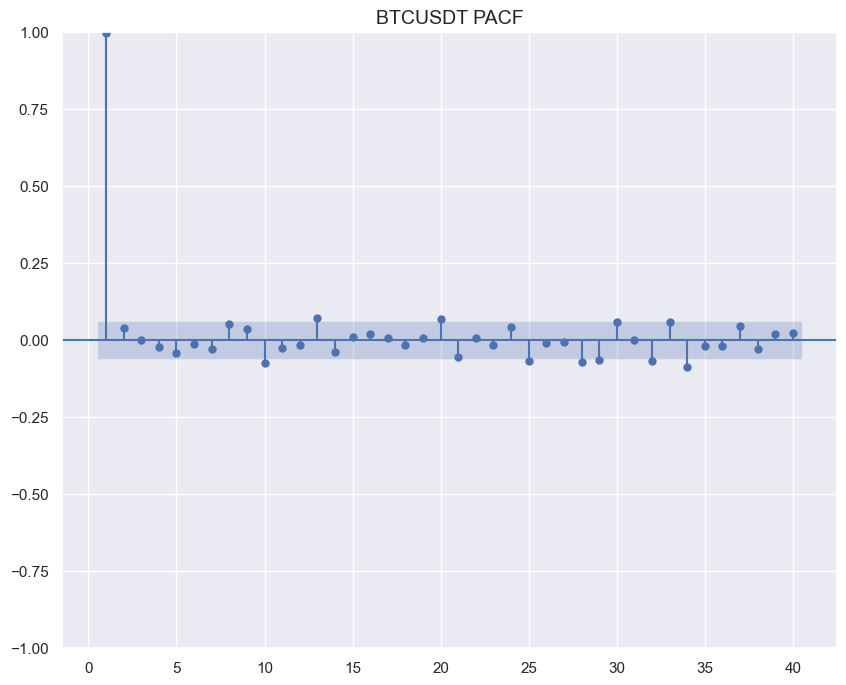

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))  
sgt.plot_pacf(df.Close, lags=40, zero=False, ax=ax, method=('ols'))
plt.title("BTCUSDT PACF", size = 14)
plt.savefig('../reports/figures/btcusdt_pacf')
plt.show()




### the pacf shows that the previous lags has little to no effect on the current price 

#### AR model

In [21]:
df = df.asfreq('d')

In [41]:
model_ar = ARIMA(df.Close, order = (15, 0, 0))
summary_ar = model_ar.fit()

In [42]:
summary_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  998
Model:                ARIMA(15, 0, 0)   Log Likelihood               -8587.562
Date:                Tue, 13 Jun 2023   AIC                          17209.124
Time:                        15:57:39   BIC                          17292.522
Sample:                    01-01-2020   HQIC                         17240.824
                         - 09-24-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.994e+04   8763.955      3.416      0.001    1.28e+04    4.71e+04
ar.L1          0.9602      0.027     35.392      0.000       0.907       1.013
ar.L2          0.0432      0.036      1.192      0.233      -0.028       0.114
ar.L3          0.0256      0.040      0.632      0.527      -0.054       0.105
ar.L4          0.0060      0.036      0.168      0.867      -0.064       0.076
ar.L5         -0.0292      0.034     -0.867      0.386      -0.095       0.037
ar.L6          0.0191      0.036      0.538      0.590      -0.051       0.089
ar.L7         -0.0831      0.034     -2.445      0.014      -0.150      -0.016
ar.L8          0.0254      0.029      0.861      0.389      -0.032       0.083
ar.L9          0.1039      0.032      3.266      0.001       0.042       0.166
ar.L10        -0.0483      0.035     -1.382      0.167      -0.117       0.020
ar.L11        -0.0129      0.035     -0.370      0.712      -0.082       0.056
ar.L12        -0.0803      0.031     -2.612      0.009      -0.141      -0.020
ar.L13         0.1054      0.031      3.362      0.001       0.044       0.167
ar.L14        -0.0478      0.033     -1.438      0.150      -0.113       0.017
ar.L15         0.0092      0.023      0.398      0.691      -0.036       0.054
sigma2      1.757e+06     15.111   1.16e+05      0.000    1.76e+06    1.76e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               771.43
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              11.46   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.69e+21. Standard errors may be unstable.
"""